In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from collections import OrderedDict
from utils import read_data, preprocessing, create_dataloader
from model import get_KMeans, RNN
from torch import nn

In [2]:
# load used countries data
used_countries = ['USA', 'CHN', 'JPN', 'DEU', 'IND', 
                  'GBR', 'FIN', 'BRA', 'ITA', 'CAN', 
                  'RUS', 'ZAF', 'AUS', 'ESP', 'MEX',
                  'IDN', 'TUR', 'NLD', 'SAU', 'CHE']
country_covid_data = read_data('data.csv', used_countries)

In [3]:
# normalized data
normalized_data = OrderedDict()
for country in used_countries:
    tem_data = np.array(country_covid_data[country]['Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'])
    normalized_data[country] = preprocessing(tem_data)

In [4]:
# clustering
classes = 3
km = get_KMeans('mine', classes) # 'mine' or 'sklearn'
Y = np.array([normalized_data[idx] for idx in normalized_data])
y_pre = km.fit_predict(Y)

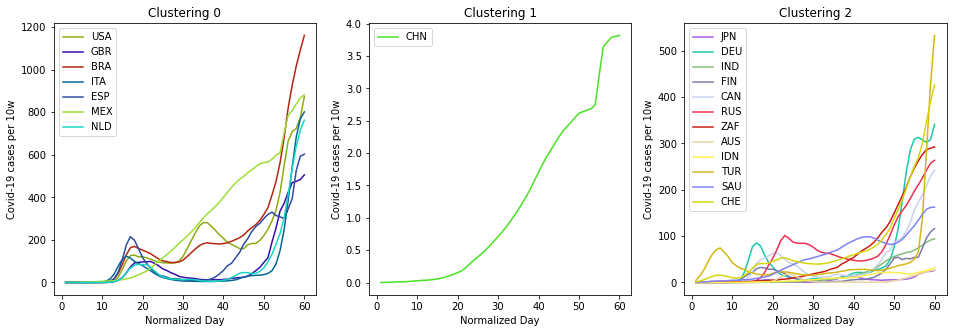

In [5]:
# show
y_pre
plt.figure(figsize=(16,5))
x_axix = np.linspace(1, 60, 60)
for i in range(classes):
   plt.subplot(1,classes,i+1)
   for j in range(len(used_countries)):
      if y_pre[j] == i:
         plt.title('Clustering {}'.format(str(i)))
         plt.plot(x_axix, Y[j], color=np.random.rand(3,), label=used_countries[j])
         plt.xlabel('Normalized Day')
         plt.ylabel('Covid-19 cases per 10w')
         plt.legend()
plt.show()


In [6]:
# RNN predict by classes from clustering

# use the most countries data(clustering 2)
dataset = np.array([data for i, data in enumerate(Y) if y_pre[i]==2])
trainloader, testloader = create_dataloader(Y)

# use RNN(LSTM) to predict
net = RNN(20, 4).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

# train
for e in range(1000):
    input = torch.from_numpy(trainloader['input']).cuda().float()
    predict = torch.from_numpy(trainloader['predict']).cuda().float()

    out = net(input)
    loss = criterion(out, predict)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0:
        print('Epoch: {}, Loss: {:.8f}'.format(e + 1, loss.item()))

# save
torch.save(net.state_dict(), './RNN.pth')

Epoch: 100, Loss: 0.00081475
Epoch: 200, Loss: 0.00026604
Epoch: 300, Loss: 0.00017594
Epoch: 400, Loss: 0.00013195
Epoch: 500, Loss: 0.00010639
Epoch: 600, Loss: 0.00008982
Epoch: 700, Loss: 0.00007872
Epoch: 800, Loss: 0.00007173
Epoch: 900, Loss: 0.00006683
Epoch: 1000, Loss: 0.00006341


In [7]:
# val
test_input = torch.from_numpy(testloader['input']).cuda().float()
test_predict = torch.from_numpy(testloader['predict']).cuda().float()
net = net.eval()
out = net(test_input)
loss = criterion(out, test_predict)
print('Val Loss: {:.5f}'.format(loss.item()))

Val Loss: 0.00013
